In [1]:
%cd ..

C:\cygwin64\home\evger\thesis


In [19]:
from typing import Union, List, Dict

import logging
logging.disable(logging.CRITICAL)

import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
from collections import defaultdict
import datetime
from hft.units.metrics import instant, composite, time as time_metric


from hft.backtesting.data import OrderStatus, OrderRequest
from hft.backtesting.strategy import Strategy
from hft.utils.data import Trade, OrderBook
from hft.backtesting import readers, backtest
from hft.backtesting.output import StorageOutput
from hft.backtesting.readers import TimeLimitedReader
from hft.units.filters import Filters
from hft.utils.consts import Statuses, QuoteSides, TradeSides

In [3]:
class GatlingMM(Strategy):
  def __init__(self, side_volume, filter=3, **kwargs):
    super().__init__(filter=filter, **kwargs)
    self.side_volume = side_volume
    self.volumes_left = {} # add cancellation policy

  def define_orders(self, row: Union[Trade, OrderBook],
                    statuses: List[OrderStatus],
                    memory: Dict[str, Union[Trade, OrderBook]],
                    is_trade: bool) -> List[OrderRequest]:
    if self.balance.get(row.symbol, None) is None:
      if not is_trade and self.balance.get(row.symbol, None) is None:
        # Initialize first orders
        ask_volume = min(self._get_allowed_volume(row.symbol, memory, QuoteSides.ASK), self.side_volume)
        self.volumes_left[(row.symbol, QuoteSides.ASK)] = self.side_volume - ask_volume
        ask_order = OrderRequest.create_ask(row.ask_prices[0], ask_volume, row.symbol, row.timestamp)

        bid_volume = min(self._get_allowed_volume(row.symbol, memory, QuoteSides.BID), self.side_volume)
        self.volumes_left[(row.symbol, QuoteSides.BID)] = self.side_volume - bid_volume
        bid_order = OrderRequest.create_bid(row.bid_prices[0], bid_volume, row.symbol, row.timestamp)

        return [ask_order, bid_order]
    elif self.balance.get(row.symbol, None) is not None:
      orders = []
      for status in statuses:
        order: OrderRequest = self.active_orders[status.id]

        if status.status != Statuses.PARTIAL: # finished and cancel
          self.volumes_left[(order.symbol, order.side)] += order.volume - order.volume_filled
        elif status.status == Statuses.PARTIAL:
          self.volumes_left[(order.symbol, order.side)] += status.volume

      for (symbol, side), left_volume in self.volumes_left.items():
        if left_volume > 500:
          volume = min(left_volume, self._get_allowed_volume(symbol, memory, side))
          self.volumes_left[(symbol, side)] -= volume

          if side == QuoteSides.BID:
            price = memory[('orderbook', symbol)].bid_prices[0]
          else:
            price = memory[('orderbook', symbol)].ask_prices[0]

          neworder = OrderRequest.create(price, volume, symbol, side, row.timestamp)
          orders.append(neworder)

      return orders
    return []

In [4]:
class OrdersOutput(StorageOutput):
  def __init__(self, instant_metric_names, time_metric_names):
    super().__init__(instant_metric_names, time_metric_names)
    self.prices = defaultdict(list)
    self.orders = defaultdict(list)
    self.snapshots = defaultdict(list)
    self.trades = defaultdict(list)
    
  def time_metric_action(self, timestamp, labels, object):
    pass

  def snapshot_action(self, timestamp: datetime.datetime, object: OrderBook):
    self.snapshots[object.symbol].append((timestamp, object.bid_prices[0], object.ask_prices[0]))

  def instant_metric_action(self, timestamp, labels, object):
    pass

  def trade_action(self, timestamp: datetime.datetime, object: Trade):
    self.trades[(object.symbol, object.side)].append((object.timestamp, object.price, object.volume))

  def additional_action(self, timestamp: datetime.datetime, labels, object: OrderRequest):
    if 'order-request' in labels:
        self.orders[(labels[1], labels[2])].append((timestamp, object.price, object.volume))

  def metric_action(self, timestamp: datetime.datetime, object):
    pass

In [5]:
def init_backtest(ob_file: str, tr_file: str, time_limit: str, output_enabled: bool, strategy_dict: Dict = {}):
  reader = TimeLimitedReader(ob_file, 
                           limit_time=time_limit,
                           skip_time=None,
                           trades_file=tr_file,
                           nrows=500000)
  
  delay = 3 # millisec
  target_contracts = 3000
  filter_depth=4
  
  if output_enabled:
    output = OrdersOutput([], [])
    output.balances = []
  else:
    output = None
  strategy = GatlingMM(target_contracts, filter=filter_depth, **strategy_dict)
  
  bt = backtest.Backtest(reader, strategy, output=output, delay=delay)
  bt.run()

In [6]:
orderbook_file =  'tests/resources/huge_dataset/orderbook_10_03_20.csv.gz'
trade_file =      'tests/resources/huge_dataset/trades_10_03_20.csv.gz'
time_limit =      '100 min'

### Gatling w/o metrics

In [7]:
no_metrics_gatling = time.time()
init_backtest(orderbook_file, trade_file, time_limit, output_enabled=False)
no_metrics_gatling = time.time() - no_metrics_gatling
print(f'No metrics Gatling took {no_metrics_gatling:.3f} seconds')

No metrics Gatling took 95.557 seconds


### Gatling+Output w/o metrics

In [8]:
no_metrics_gatling_output = time.time()
init_backtest(orderbook_file, trade_file, time_limit, output_enabled=True)
no_metrics_gatling_output = time.time() - no_metrics_gatling_output
print(f'No metrics Gatling+output took {no_metrics_gatling_output:.3f} seconds')

No metrics Gatling+output took 99.109 seconds


### One metric Gatling: Instant VWAP 

In [9]:
vwap = instant.VWAP_volume([int(5e5), int(1e6), int(1.5e6)])

one_metric_gatling = time.time()
init_backtest(orderbook_file, trade_file, time_limit, output_enabled=False, strategy_dict={'instant_metrics': [vwap]})
one_metric_gatling = time.time() - one_metric_gatling
print(f'One metric Gatling took {one_metric_gatling:.3f} seconds')

One metric Gatling took 284.750 seconds


### One metric Gatling+Output: Instant VWAP 

In [10]:
vwap = instant.VWAP_volume([int(5e5), int(1e6), int(1.5e6)])

one_metric_gatling_output = time.time()
init_backtest(orderbook_file, trade_file, time_limit, output_enabled=True, strategy_dict={'instant_metrics': [vwap]})
one_metric_gatling_output = time.time() - one_metric_gatling_output
print(f'One metric Gatling took {one_metric_gatling_output:.3f} seconds')

One metric Gatling took 275.898 seconds


### Two metric Gatling: Instant VWAP and TradeMetric (60 sec)

In [11]:
vwap = instant.VWAP_volume([int(5e5), int(1e6), int(1.5e6)])

defaults = [
    (('XBTUSD', 0), [0.0]),
    (('XBTUSD', 1), [0.0]),
    (('ETHUSD', 0), [0.0]),
    (('ETHUSD', 1), [0.0]),
  ]
trades = time_metric.TradeMetric(defaults, [('total', lambda trades: sum(map(lambda x: x.volume, trades)))], seconds=60, name='firefly')

two_metric_gatling = time.time()
init_backtest(orderbook_file, trade_file, time_limit, 
              output_enabled=False, 
              strategy_dict={'instant_metrics': [vwap], 
                             'time_metrics_trade': [trades]})

two_metric_gatling = time.time() - two_metric_gatling
print(f'Two metric Gatling took {two_metric_gatling:.3f} seconds')

Two metric Gatling took 278.637 seconds


### Two metric Gatling+Output: Instant VWAP and TradeMetric (60 sec)

In [12]:
vwap = instant.VWAP_volume([int(5e5), int(1e6), int(1.5e6)])

defaults = [
    (('XBTUSD', 0), [0.0]),
    (('XBTUSD', 1), [0.0]),
    (('ETHUSD', 0), [0.0]),
    (('ETHUSD', 1), [0.0]),
  ]
trades = time_metric.TradeMetric(defaults, [('total', lambda trades: sum(map(lambda x: x.volume, trades)))], seconds=60, name='firefly')

two_metric_gatling_output = time.time()
init_backtest(orderbook_file, trade_file, time_limit, 
              output_enabled=True, 
              strategy_dict={'instant_metrics': [vwap], 
                             'time_metrics_trade': [trades]})

two_metric_gatling_output = time.time() - two_metric_gatling_output
print(f'Two metric Gatling took {two_metric_gatling_output:.3f} seconds')

Two metric Gatling took 282.335 seconds


### Three metric Galting: Instant VWAP, Delta Hayashi-Yoshido and TradeMetric (60sec)

In [21]:
vwap = instant.VWAP_volume([int(5e5), int(1e6), int(1.5e6)])
hy = instant.HayashiYoshido(seconds=120)

defaults = [
    (('XBTUSD', 0), [0.0]),
    (('XBTUSD', 1), [0.0]),
    (('ETHUSD', 0), [0.0]),
    (('ETHUSD', 1), [0.0]),
  ]
trades = time_metric.TradeMetric(defaults, [('total', lambda trades: sum(map(lambda x: x.volume, trades)))], seconds=60, name='firefly')

three_metric_gatling = time.time()
init_backtest(orderbook_file, trade_file, time_limit, 
              output_enabled=True, 
              strategy_dict={'instant_metrics': [vwap], 
                             'time_metrics_trade': [trades],
                             'delta_metrics': [hy]})

three_metric_gatling = time.time() - three_metric_gatling
print(f'Three metric Gatling took {three_metric_gatling:.3f} seconds')

Three metric Gatling took 427.922 seconds


### Four metric Gatling: VWAP, HY, TradeMetric and Lipton

In [22]:
vwap = instant.VWAP_volume([int(5e5), int(1e6), int(1.5e6)])
hy = instant.HayashiYoshido(seconds=120)
lipton = composite.Lipton(hy.name, 6)

defaults = [
    (('XBTUSD', 0), [0.0]),
    (('XBTUSD', 1), [0.0]),
    (('ETHUSD', 0), [0.0]),
    (('ETHUSD', 1), [0.0]),
  ]
trades = time_metric.TradeMetric(defaults, [('total', lambda trades: sum(map(lambda x: x.volume, trades)))], seconds=60, name='firefly')

four_metric_gatling = time.time()
init_backtest(orderbook_file, trade_file, time_limit, 
              output_enabled=True, 
              strategy_dict={'instant_metrics': [vwap], 
                             'time_metrics_trade': [trades],
                             'delta_metrics': [hy],
                             'composite_metrics': [lipton]})

four_metric_gatling = time.time() - four_metric_gatling
print(f'Four metric Gatling took {four_metric_gatling:.3f} seconds')

Four metric Gatling took 473.795 seconds


## Visualize performance

Time consumption include IO operations: reading files with offset and processing dataframes 

In [23]:
import matplotlib.pyplot as plt

historic_time_spent = 100 * 60 # 100 minutes
total_events = 629790.0 # refer to Gatling.ipynb
seconds = [no_metrics_gatling, 
           one_metric_gatling, 
           two_metric_gatling,
           three_metric_gatling,
           four_metric_gatling]

iterations = [total_events / sec for sec in seconds]
speed = [historic_time_spent / sec for sec in seconds]

In [24]:
iterations

[6590.752204468699,
 2211.7264614203464,
 2260.2523055869156,
 1471.7401927640324,
 1329.245573313603]

In [25]:
speed

[62.789998613525455,
 21.071085232414106,
 21.533390230904732,
 14.021247013423832,
 12.66370288490071]

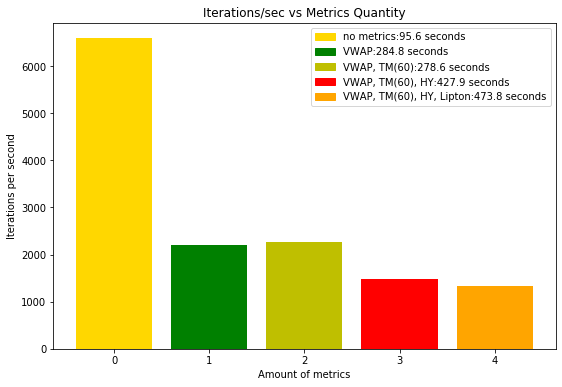

In [41]:
import matplotlib.patches as mpatches
plt.figure(figsize=(9,6))
x = range(0, 5)
# y = (1,2,3,4,5)
y = iterations

colors = ['gold', 'g', 'y', 'r', 'orange']
contents = [
    'no metrics',
    'VWAP',
    'VWAP, TM(60)',
    'VWAP, TM(60), HY',
    'VWAP, TM(60), HY, Lipton'
]


patches = [mpatches.Patch(color=c, label=f'{msg}:{sec:.1f} seconds') for c, msg, sec in zip(colors, contents, seconds)]

plt.bar(x,y,align='center', color=colors) # A bar chart
plt.legend(handles=patches, loc=1)
plt.xlabel('Amount of metrics')
plt.ylabel('Iterations per second')
plt.title('Iterations/sec vs Metrics Quantity')
plt.show()